# Natural Language Processing with Disaster Tweets


## The Problem and Data

The problem that this notebook is trying to solve is figuring out if a real-time tweet is talking about a disaster or not. Using Natural Language Processing (NLP) to classify these tweets and learn what really is disaster tweet and what isn't.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import keras as K
import keras_nlp

from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')

from nltk.corpus import  stopwords

2025-04-15 22:13:57.709392: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 22:13:57.781162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744769637.833465  544225 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744769637.841524  544225 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744769637.899947  544225 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

I was fortunate enough to use my GPU to help accelerate training via tensorflow

In [4]:
# Using GPU to do training.
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# EDA
Loading the data

In [3]:
train_data_df = pd.read_csv("train.csv")
test_data_df = pd.read_csv("test.csv")
sample_data_df = pd.read_csv("sample_submission.csv")

Data dimensions and size

In [4]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
sample_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


## Empty Data!
We're not removing rows with empty data as keyword and location aren't really the main focus - simply if a set amount of text is a disaster or not.

In [17]:
print(train_data_df.isna().sum())
print(test_data_df.isna().sum())
print(sample_data_df.isna().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64
id        0
target    0
dtype: int64


In [18]:
train_data_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
train_data_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


What does the text look like?

In [102]:
for x in range(20):
    print(train_data_df["text"][x])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida 

### Text Preprocessing

We're going to do some clean up like removing hashtags, lowercasing everything, numbers, and all stop-words.

In [5]:
def preprocess_text(text):
    # Remove http links
    text = re.sub(r'https?://\S+', '', text)
    # Remove hashtags
    text = text.replace("#", "")
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    # Lowercase everything
    text = text.lower()
    # Remove stop-words
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [6]:
train_data_df["text"] = train_data_df["text"].apply(preprocess_text)

In [105]:
for x in range(20):
    print(train_data_df["text"][x])

deeds reason earthquake may allah forgive us
forest fire near la ronge sask canada
residents asked shelter place notified officers evacuation shelter place orders expected
 people receive wildfires evacuation orders california
got sent photo ruby alaska smoke wildfires pours school
rockyfire update  california hwy closed directions due lake county fire  cafire wildfires
flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
top hill see fire woods
theres emergency evacuation happening building across street
afraid tornado coming area
three people died heat wave far
haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding
raining flooding florida tampabay tampa days lost count
flood bago myanmar arrived bago
damage school bus multi car crash breaking
whats man
love fruits
summer lovely
car fast
goooooooaaaaaal


### Visualizations

In [94]:
target_counts = train_data_df["target"].value_counts()


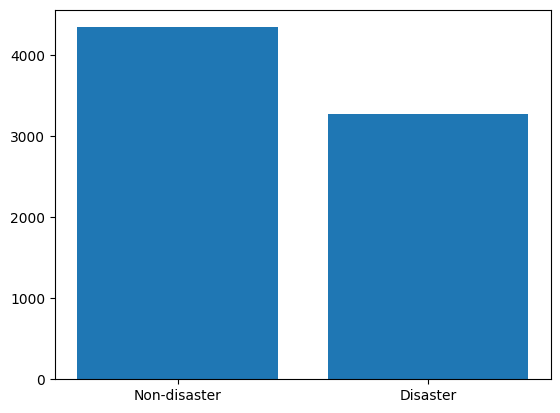

<Figure size 500x500 with 0 Axes>

In [106]:
plt.bar(x=["Non-disaster", "Disaster"], height=target_counts)
plt.figure(figsize=(5,5))
plt.show()

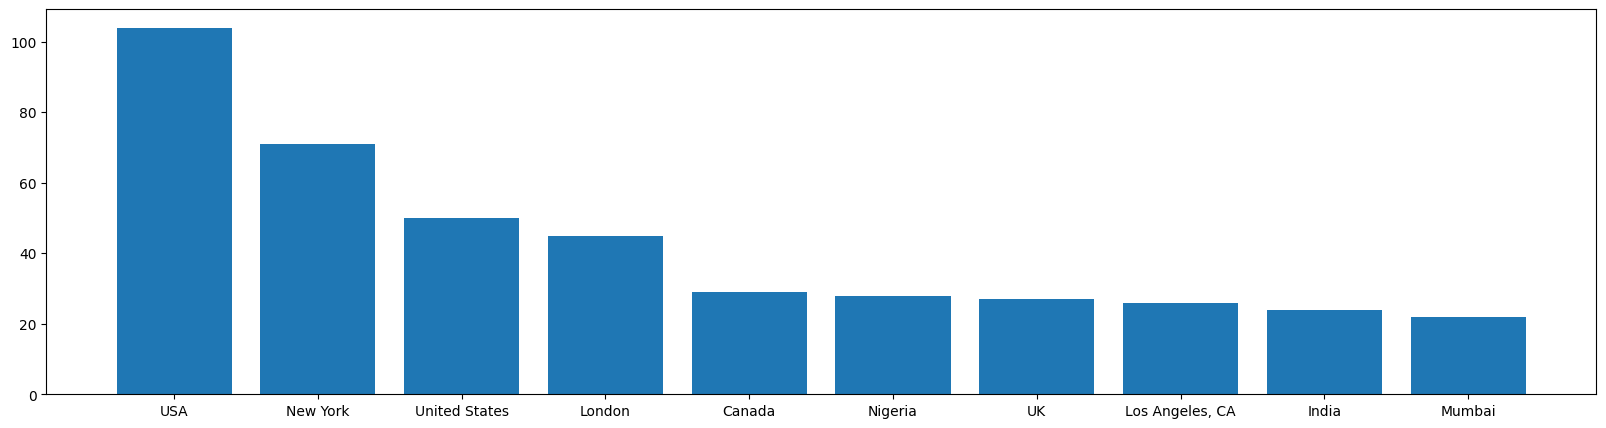

In [107]:
# Top ten locations
location_counts = train_data_df["location"].value_counts()[:10]
plt.figure(figsize=(20,5))
plt.bar(x=location_counts.index, height=location_counts)
plt.show()

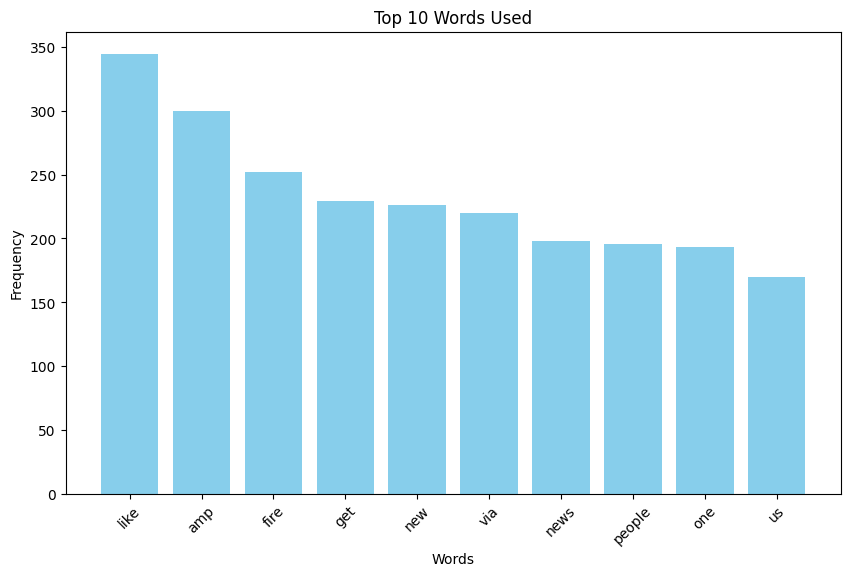

In [109]:
# Top 10 words
all_text = " ".join(train_data_df["text"])
word_counts = Counter(all_text.split())
top_words = word_counts.most_common(10)
words, counts = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Used')
plt.xticks(rotation=45)
plt.show()

# Deep Learning Model

We'll be using `KerasNLP` and a pre-trained `DistilBERT` model from that framework. `BERT` is `Bidirectional Encoder Representations from Transformers.` They are able to "compute vector-space representations of natural languages to be used in deep learning models. `DistilBERT` is simply a smaller version, 40% smaller, than BERT while maintain 40% knowledge and retaining 97% accuracy and being 60% faster." This model is suitable for this problem to classify disaster and non-disaster tweets due to the natural language processing.

In [37]:
epochs = 10
batch_size = 16
training_examples = train_data_df.shape[0]
train_amount = 0.7
val_amount = 0.3
steps = int(training_examples) * train_amount // batch_size

auto_tune = tf.data.experimental.AUTOTUNE

X = train_data_df["text"]
y = train_data_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_amount, random_state=123)

X_test = test_data_df["text"]

In [38]:
preset = "distil_bert_base_en_uncased"

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="preprocessor_4_tweets")

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,                                                               preprocessor=preprocessor,
    num_classes=2)

In [22]:
second_classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,                                                               preprocessor=preprocessor,
    num_classes=2)


second_classifier.compile(
    loss=K.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=K.optimizers.Adam(1e-6),
    metrics= ["accuracy"]
)
second_model = second_classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(X_val, y_val)
                         )

Epoch 1/10


2025-04-15 23:02:01.112419: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 80 bytes spill stores, 60 bytes spill loads



 29/215 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.5193 - loss: 0.6911

215/215 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.5819 - loss: 0.6809 - val_accuracy: 0.7454 - val_loss: 0.6184
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.7799 - loss: 0.5773 - val_accuracy: 0.7874 - val_loss: 0.4986
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - accuracy: 0.8039 - loss: 0.4738 - val_accuracy: 0.7900 - val_loss: 0.4738
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step - accuracy: 0.8153 - loss: 0.4391 - val_accuracy: 0.7953 - val_loss: 0.4651
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 39s 180ms/step - accuracy: 0.8193 - loss: 0.4229 - val_accuracy: 0.7992 - val_loss: 0.4605
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.8314 - loss: 0.4066 - val_accuracy: 0.8018 - val_loss: 0.4559
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 157ms/step - accuracy: 0.8385 - loss: 0.3947 - val_accuracy: 0.7992 - val_loss: 0.4528
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - accuracy: 0.8404 - loss: 0.3865 - val

215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


Text(0.5, 1.0, 'Confusion Matrix on Training Dataset - F1 Score: 0.83')

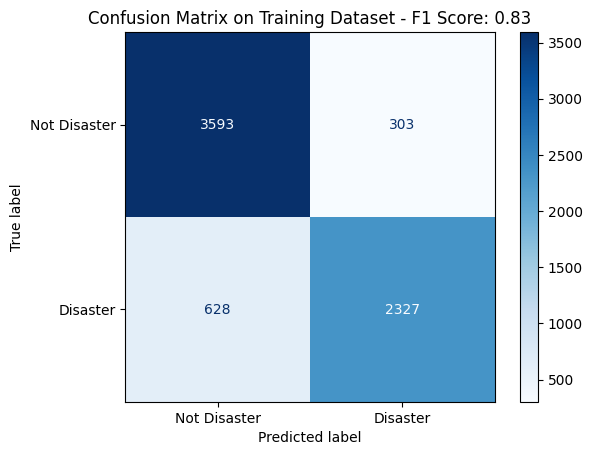

In [23]:
y_pred_train = second_classifier.predict(X_train)

display_train = ConfusionMatrixDisplay.from_predictions(
    y_train,
    np.argmax(y_pred_train, axis=1),
    display_labels=["Not Disaster","Disaster"],
    cmap=plt.cm.Blues
)

tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_pred_train, axis=1)).ravel()
f1_score = tp / (tp+((fn+fp)/2))

display_train.ax_.set_title(f"Confusion Matrix on Training Dataset - F1 Score: {f1_score.round(2)}")

Initial score of 0.83 against our training data.

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step


Text(0.5, 1.0, 'Confusion Matrix on Training Dataset - F1 Score: 0.75')

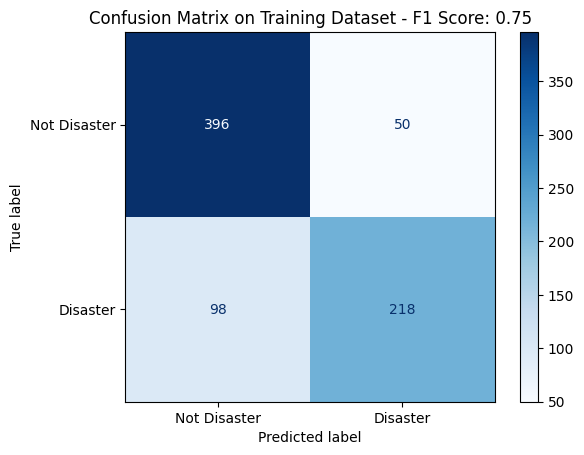

In [24]:
y_pred_val = second_classifier.predict(X_val)

display_valid = ConfusionMatrixDisplay.from_predictions(
    y_val,
    np.argmax(y_pred_val, axis=1),
    display_labels=["Not Disaster","Disaster"],
    cmap=plt.cm.Blues
)

tn, fp, fn, tp = confusion_matrix(y_val, np.argmax(y_pred_val, axis=1)).ravel()
f1_score = tp / (tp+((fn+fp)/2))

display_valid.ax_.set_title(f"Confusion Matrix on Training Dataset - F1 Score: {f1_score.round(2)}")

Test score of 0.75, not too bad. Let's try some minor hyperparameter tuning.

# Hyperparameter Tuning

- Changes
    - Epoches from 10 to 2.
    - Training size from 0.7 to 0.8
    - The learning rate from 1e-6 to 1e-5.
    - Batch size from 16 to 32.

Initially tried doubling or halving numeric hyperparameter values until I got an increase in accuracy.

I tried changing batch size higher but this lead to less accurate results.

Increasing the learning rate too much made the model incredibly inaccurate.

In [25]:
batch_size = 32
training_examples = train_data_df.shape[0]
train_amount = 0.8
val_amount = 0.2
steps = int(training_examples) * train_amount // batch_size

epochs = 2
auto_tune = tf.data.experimental.AUTOTUNE

X = train_data_df["text"]
y = train_data_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_amount, random_state=123)

X_test = test_data_df["text"]

In [26]:
preset = "distil_bert_base_en_uncased"

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=160,
    name="preprocessor_4_tweets")

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,                                                               preprocessor=preprocessor,
    num_classes=2)

In [27]:
classifier.compile(
    loss=K.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=K.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)
first_model = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(X_val, y_val)
                         )

Epoch 1/2


2025-04-15 23:12:09.615353: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 544 bytes spill stores, 544 bytes spill loads

2025-04-15 23:12:09.732221: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 180 bytes spill stores, 180 bytes spill loads

2025-04-15 23:12:09.758219: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 184 bytes spill stores, 184 bytes spill loads

2025-04-15 23:12:09.778609: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 876 bytes spill stores, 844 bytes spill loads

2025-04-15 23:12:09.780036: I externa

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7016 - loss: 0.5768

2025-04-15 23:13:22.614925: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 240 bytes spill stores, 240 bytes spill loads

2025-04-15 23:13:22.628182: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 248 bytes spill stores, 248 bytes spill loads

2025-04-15 23:13:22.660176: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 432 bytes spill stores, 344 bytes spill loads

2025-04-15 23:13:22.694501: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 632 bytes spill stores, 632 bytes spill loads

2025-04-15 23:13:22.780982: I extern

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7020 - loss: 0.5764

2025-04-15 23:13:42.080043: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 632 bytes spill stores, 632 bytes spill loads

2025-04-15 23:13:42.115815: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 888 bytes spill stores, 888 bytes spill loads

2025-04-15 23:13:42.129537: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 180 bytes spill stores, 180 bytes spill loads

2025-04-15 23:13:42.139612: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 432 bytes spill stores, 344 bytes spill loads

2025-04-15 23:13:42.150294: I external/l

191/191 ━━━━━━━━━━━━━━━━━━━━ 106s 421ms/step - accuracy: 0.7023 - loss: 0.5760 - val_accuracy: 0.8102 - val_loss: 0.4317
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 53s 231ms/step - accuracy: 0.8364 - loss: 0.3957 - val_accuracy: 0.8194 - val_loss: 0.4116


### Training Accuracy
Let's see what our training accuracy looks like

189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

2025-04-15 23:14:55.282070: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1886', 96 bytes spill stores, 96 bytes spill loads

2025-04-15 23:14:55.435337: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1886', 924 bytes spill stores, 924 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step


Text(0.5, 1.0, 'Confusion Matrix on Training Dataset - F1 Score: 0.85')

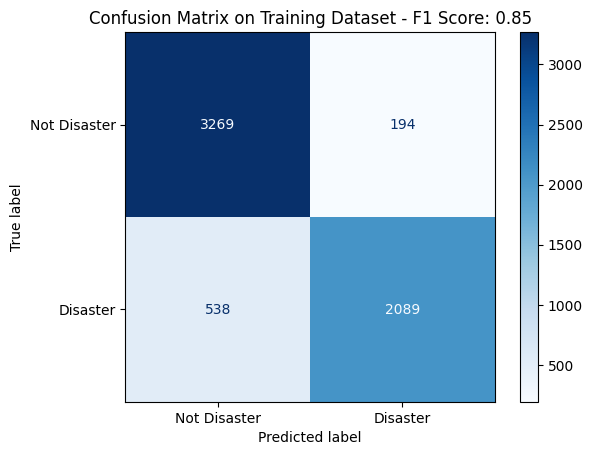

In [28]:
y_pred_train = classifier.predict(X_train)

display_train = ConfusionMatrixDisplay.from_predictions(
    y_train,
    np.argmax(y_pred_train, axis=1),
    display_labels=["Not Disaster","Disaster"],
    cmap=plt.cm.Blues
)

tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_pred_train, axis=1)).ravel()
f1_score = tp / (tp+((fn+fp)/2))

display_train.ax_.set_title(f"Confusion Matrix on Training Dataset - F1 Score: {f1_score.round(2)}")

We got an F1 score of 0.85 which is pretty good for our slightly more optimized training data.

### Test Accuracy

48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step


Text(0.5, 1.0, 'Confusion Matrix on Training Dataset - F1 Score: 0.77')

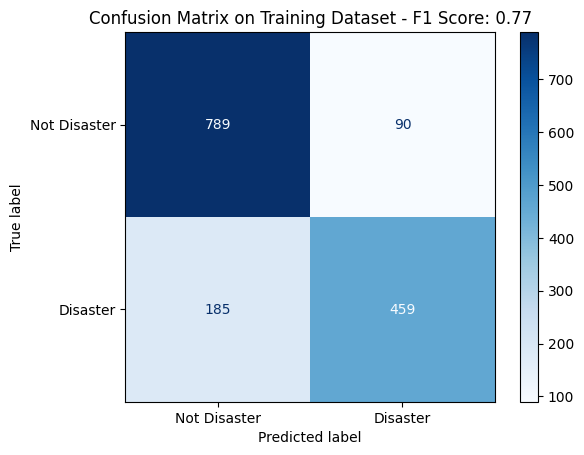

In [29]:
y_pred_val = classifier.predict(X_val)

display_valid = ConfusionMatrixDisplay.from_predictions(
    y_val,
    np.argmax(y_pred_val, axis=1),
    display_labels=["Not Disaster","Disaster"],
    cmap=plt.cm.Blues
)

tn, fp, fn, tp = confusion_matrix(y_val, np.argmax(y_pred_val, axis=1)).ravel()
f1_score = tp / (tp+((fn+fp)/2))

display_valid.ax_.set_title(f"Confusion Matrix on Training Dataset - F1 Score: {f1_score.round(2)}")

Our test accuracy went up slightly as well by 0.02.

# Second Model Logistical Regression
Using TF-IDF which converts text to numerical representations to allow it to be used by the machine learning models like LogisticRegression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
vectorizer = TfidfVectorizer()

target_train = train_data_df["target"]

text_train = tfidf.fit_transform(train_data_df["text"])
text_test = tfidf.transform(test_data_df["text"])
print('Text train shape:', text_train.shape)

X_train, X_val, y_train, y_val = train_test_split(text_train, target_train, test_size=0.25, random_state=123)

Text train shape: (7613, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

log_reg_model = LogisticRegression(max_iter=750, random_state=123)
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1097
           1       0.83      0.68      0.74       807

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904

Confusion Matrix:
[[985 112]
 [262 545]]


That took no time at all to get a training accuracy of 0.80 compared to the deep learning model.

### Checking Actual Test Accuracy

In [36]:
y_pred_test = log_reg_model.predict(text_test)

accuracy = accuracy_score(sample_data_df["target"], y_pred_test)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.73


Our accuracy is slightly lower at 0.73 but the time savings is incomparable, almost instant versus 20 minutes of training against the deep learning model.

# Conclusion

- Deep learning models with `DistilBert` took about 20 minutes to learn the data and was able to more easily predict unseen data compared to my Supervised learning model with LogisticRegression.
- LogisticRegression speed was almost instant in comparison to the deep learning model while only being 0.05 less accurate on the test data.
- I would like to run some automated hyperparameter optimizations on the deep learning model but didn't for the sake of time left in the class.
- Increasing batch size for the deep learning model made it much worse in accuracy, I dropped to around 50% on training accuracy.
- On smaller datasets, it might be more worthwhile to try supervised models for quick and easy efficiency and leave the deep learning for massive datasets.

# References
Keras. (n.d.). Getting started with Keras Hub. Retrieved April 15, 2025, from https://keras.io/keras_hub/getting_started/

Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2020). DistilBERT, a distilled version of BERT: Smaller, faster, cheaper and lighter. arXiv. https://doi.org/10.48550/arXiv.1910.01108